Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


## Загрузка данных

In [1]:
import gdown                                      # Подключим функцию gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)      # Скачивание файла

'20writers.zip'

In [2]:
!unzip -qo 20writers.zip -d 20writers/

In [3]:
!ls 20writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
# Работа с таблицами
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    SpatialDropout1D,
    BatchNormalization,
    Embedding,
    Flatten,
    Activation,
)

from tensorflow.keras.optimizers import Adam

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time

In [5]:
path = Path("20writers")
text = []
class_names = []
for f in path.iterdir():
    class_names.append(f.name)
    text.append(f.read_text().replace("\n", " "))

In [6]:
text_lens = [len(t) for t in text]
split_indices = [int(lenth * 0.8) for lenth in text_lens]
print(text_lens)

[2328900, 2579246, 3089426, 3357061, 3104712, 1972541, 2399413, 6611627, 3386268, 3408339, 2001064, 2152214, 1980206, 5178950, 2952792, 969109, 2255254, 1965119, 2523380, 1992830]


In [7]:
train_text = []
test_text = []
for i, t in enumerate(text):
    train_text.append(t[:split_indices[i]])
    test_text.append(t[split_indices[i]:])

In [8]:
VOCAB_SIZE = 25_000
WIN_SIZE = 4000
WIN_HOPE = 500

def split_sequence(sequence, win_size, hop):
    # Разбить последовательность на части
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]


# Функция формирования выборок из последовательностей индексов
def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)

    x, y = [], []

    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [9]:
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))

In [10]:
with timex():
    tokenizer = Tokenizer(
        num_words=VOCAB_SIZE,
        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
        lower=True,
        split=" ",
        oov_token="неизвестное_слово",
        char_level=False,
    )
    tokenizer.fit_on_texts(text)
    seq_train = tokenizer.texts_to_sequences(train_text)
    seq_test = tokenizer.texts_to_sequences(test_text)
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)
with timex():
    x_train_matrix = tokenizer.sequences_to_matrix(x_train.tolist()).astype("float16")
with timex():
    x_test_matrix = tokenizer.sequences_to_matrix(x_test.tolist()).astype("float16")

Время обработки: 26.25 с
Время обработки: 18.85 с
Время обработки: 5.15 с


In [11]:
# Преобразование one-hot обратно в метки классов
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

# Подсчёт с помощью bincount
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Вывод результатов
print("Обучающая выборка:")
for cls, count in enumerate(train_counts):
    print(f"Класс {cls}: {count} окон")

print("\nТестовая выборка:")
for cls, count in enumerate(test_counts):
    print(f"Класс {cls}: {count} окон")

Обучающая выборка:
Класс 0: 558 окон
Класс 1: 602 окон
Класс 2: 726 окон
Класс 3: 829 окон
Класс 4: 780 окон
Класс 5: 488 окон
Класс 6: 586 окон
Класс 7: 1656 окон
Класс 8: 791 окон
Класс 9: 823 окон
Класс 10: 470 окон
Класс 11: 537 окон
Класс 12: 484 окон
Класс 13: 1294 окон
Класс 14: 706 окон
Класс 15: 239 окон
Класс 16: 532 окон
Класс 17: 479 окон
Класс 18: 647 окон
Класс 19: 479 окон

Тестовая выборка:
Класс 0: 134 окон
Класс 1: 143 окон
Класс 2: 171 окон
Класс 3: 206 окон
Класс 4: 188 окон
Класс 5: 117 окон
Класс 6: 150 окон
Класс 7: 422 окон
Класс 8: 201 окон
Класс 9: 194 окон
Класс 10: 111 окон
Класс 11: 121 окон
Класс 12: 116 окон
Класс 13: 327 окон
Класс 14: 169 окон
Класс 15: 52 окон
Класс 16: 127 окон
Класс 17: 115 окон
Класс 18: 153 окон
Класс 19: 115 окон


In [12]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [17]:
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1),
)
class_weight_dict = dict(enumerate(class_weights))

In [24]:
model = Sequential(
    [
        Input((VOCAB_SIZE,)),
        Dropout(0.6),
        Dense(64, activation="relu"),
        Dropout(0.6),
        Dense(20, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    x_train_matrix,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test_matrix, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.2514 - loss: 2.4668 - val_accuracy: 0.9508 - val_loss: 0.6407
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8703 - loss: 0.4965 - val_accuracy: 0.9682 - val_loss: 0.2719
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9492 - loss: 0.2157 - val_accuracy: 0.9706 - val_loss: 0.1923
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9638 - loss: 0.1521 - val_accuracy: 0.9715 - val_loss: 0.1626
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9724 - loss: 0.1231 - val_accuracy: 0.9706 - val_loss: 0.1436
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9773 - loss: 0.0950 - val_accuracy: 0.9709 - val_loss: 0.1339
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9801 - loss: 0.0778 - val_accuracy: 0.9715 - val_loss: 0.1189
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9804 - loss: 0.0707 - val_accuracy: 0.9715 - v

In [25]:
def eval_model(
    model, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


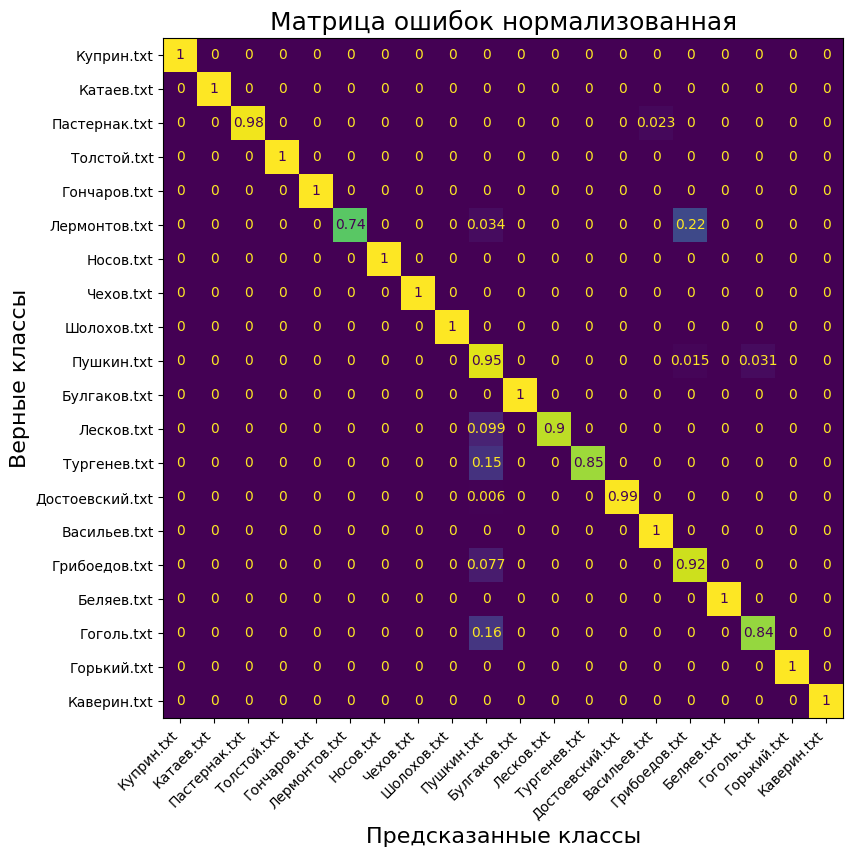

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Куприн.txt           100% сеть отнесла к классу Куприн.txt           - ВЕРНО :-)
Класс: Катаев.txt           100% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Пастернак.txt         98% сеть отнесла к классу Пастернак.txt        - ВЕРНО :-)
Класс: Толстой.txt          100% сеть отнесла к классу Толстой.txt          - ВЕРНО :-)
Класс: Гончаров.txt         100% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Лермонтов.txt         74% сеть отнесла к классу Лермонтов.txt        - ВЕРНО :-)
Класс: Носов.txt            100% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс: Чехов.txt            100% сеть отнесла к классу Чехов.txt            - ВЕРНО :-)
Класс: Шолохов.txt          100% сеть отнесла к классу Шолохов.txt          - ВЕРНО :-)
Класс: Пушкин.txt            95% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: 

In [26]:
eval_model(model, x_test_matrix, y_test, class_names)

In [20]:
model_emb = Sequential(
    [
        Embedding(VOCAB_SIZE, 400, input_length=WIN_SIZE),
        SpatialDropout1D(0.4),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(20, activation="softmax"),
    ]
)
model_emb.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_emb = model_emb.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 356ms/step - accuracy: 0.1188 - loss: 2.8256 - val_accuracy: 0.5381 - val_loss: 1.7712
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8816 - loss: 0.4295 - val_accuracy: 0.7239 - val_loss: 1.0776
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9905 - loss: 0.0685 - val_accuracy: 0.7533 - val_loss: 0.8991
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9942 - loss: 0.0364 - val_accuracy: 0.7959 - val_loss: 0.7914
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9968 - loss: 0.0220 - val_accuracy: 0.7941 - val_loss: 0.7836
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9971 - loss: 0.0174 - val_accuracy: 0.8061 - val_loss: 0.7278
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9982 - loss: 0.0141 - val_accuracy: 0.8007 - val_loss: 0.7435
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9982 - loss: 0.0107 - val_accuracy

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


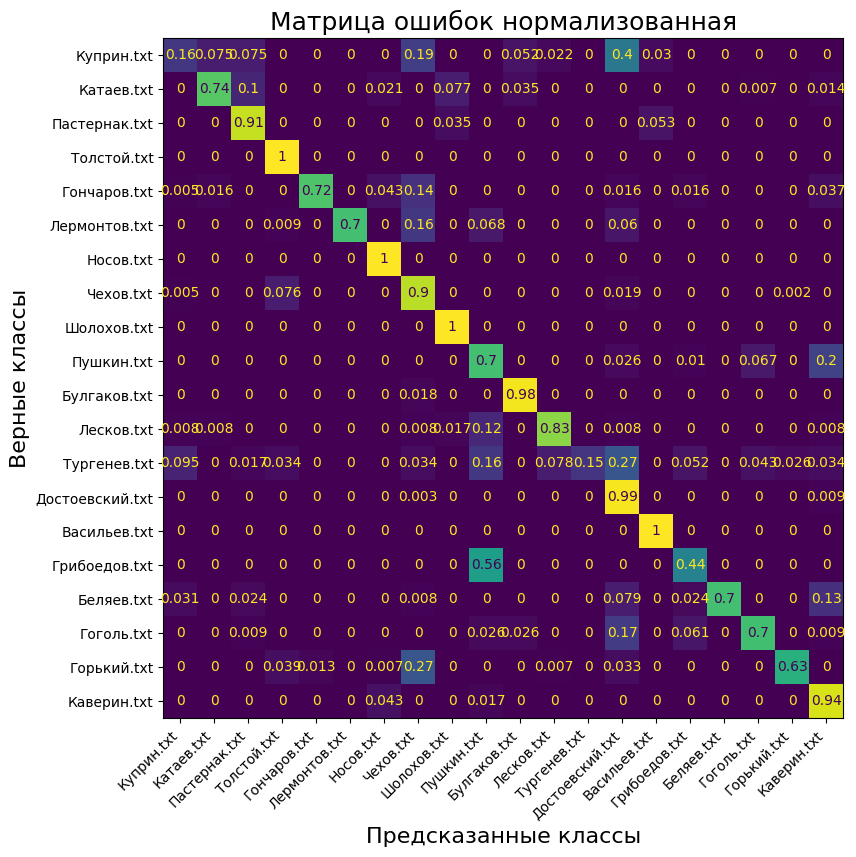

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Куприн.txt            40% сеть отнесла к классу Достоевский.txt      - НЕВЕРНО :-(
Класс: Катаев.txt            74% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Пастернак.txt         91% сеть отнесла к классу Пастернак.txt        - ВЕРНО :-)
Класс: Толстой.txt          100% сеть отнесла к классу Толстой.txt          - ВЕРНО :-)
Класс: Гончаров.txt          72% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Лермонтов.txt         70% сеть отнесла к классу Лермонтов.txt        - ВЕРНО :-)
Класс: Носов.txt            100% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс: Чехов.txt             90% сеть отнесла к классу Чехов.txt            - ВЕРНО :-)
Класс: Шолохов.txt          100% сеть отнесла к классу Шолохов.txt          - ВЕРНО :-)
Класс: Пушкин.txt            70% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс

In [27]:
eval_model(model_emb, x_test, y_test, class_names)